# Clustering for Grouping the People based on TFM and TLM

Loaded main dataset with shape: (14740, 15)
Merged dataset with CV-level. Shape: (5177, 16)
Sample fat percentage values:
   total_fat_mass  total_lean_mass  fat_percentage  fat_percentage_scaled
0        29215.50         64392.20        0.312106              31.210573
1        25022.80         35279.50        0.414956              41.495598
4        29338.58         53270.44        0.355150              35.514984
6        33395.56         51964.42        0.391232              39.123205
7        34758.90         41871.80        0.453590              45.358975
Shape of data_with_scaled: (5177, 4)


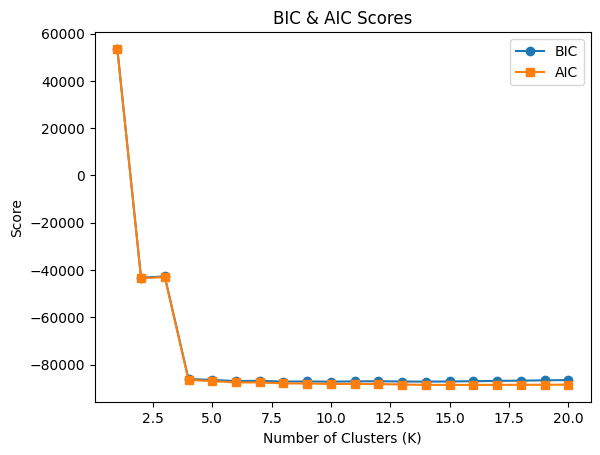

Optimal K (WITH TLM/TFM): 10
Total feature names: 4
Key Features for Clustering Decision (WITH TLM/TFM):
fat_percentage          0.484584
cv_fitness_level_2.0    0.229757
cv_fitness_level_3.0    0.174578
bmi                     0.111081
dtype: float64


In [151]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ---------------------------------------------------------------
# 1. LOAD AND MERGE THE DATA
# ---------------------------------------------------------------
data_path = "data/nhanes_cleaned_validated_data.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Ensure the preprocessing step was completed.")

health_data = pd.read_csv(data_path)
print(f"Loaded main dataset with shape: {health_data.shape}")

# Load and merge cardiovascular fitness data
cv_data1 = pd.read_csv('csv/1999_2000/cv_level.csv')
cv_data2 = pd.read_csv('csv/2001_2002/cv_level.csv')
cv_data3 = pd.read_csv('csv/2003_2004/cv_level.csv')
cv_data = pd.concat([cv_data1, cv_data2, cv_data3], ignore_index=True)
health_data_with_cv = health_data.merge(cv_data, on='id', how='inner').dropna()
print(f"Merged dataset with CV-level. Shape: {health_data_with_cv.shape}")

# ---------------------------------------------------------------
# 2. ADD BMI CATEGORY AND FAT PERCENTAGE
# ---------------------------------------------------------------
# Define BMI bins and labels (WHO standard)
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
health_data_with_cv['bmi_category'] = pd.cut(health_data_with_cv['bmi'], bins=bmi_bins, labels=bmi_labels)

# Calculate fat percentage: TFM / (TFM + TLM)
health_data_with_cv['fat_percentage'] = health_data_with_cv['total_fat_mass'] / (
    health_data_with_cv['total_fat_mass'] + health_data_with_cv['total_lean_mass']
)

# Multiply fat percentage to force higher influence
health_data_with_cv['fat_percentage_scaled'] = health_data_with_cv['fat_percentage'] * 100

print("Sample fat percentage values:")
print(health_data_with_cv[['total_fat_mass', 'total_lean_mass', 'fat_percentage', 'fat_percentage_scaled']].head())

# ---------------------------------------------------------------
# 3. DEFINE FEATURE SETS FOR CLUSTERING (WITHOUT BMI CATEGORY)
# ---------------------------------------------------------------
# For clustering WITH TLM/TFM we use:
#   - Numerical: age and scaled fat percentage
#   - Categorical: only cv_fitness_level (exclude bmi_category so it doesn't overshadow fat percentage)
numerical_features_with = ['fat_percentage', 'bmi']
categorical_features = ['cv_fitness_level']  # Only use cv fitness level as categorical

# (For clustering WITHOUT TLM/TFM, you can define another set if needed)

# ---------------------------------------------------------------
# 4. ENCODE CATEGORICAL FEATURES & SCALE DATA
# ---------------------------------------------------------------
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(health_data_with_cv[categorical_features])
encoded_df = pd.DataFrame(encoded_categorical, 
                          columns=encoder.get_feature_names_out(categorical_features),
                          index=health_data_with_cv.index)

# Combine numerical features and encoded categorical features
data_with = pd.concat([health_data_with_cv[numerical_features_with], encoded_df], axis=1)
scaler = StandardScaler()
data_with_scaled = scaler.fit_transform(data_with)
print("Shape of data_with_scaled:", data_with_scaled.shape)

# ---------------------------------------------------------------
# 5. FIND OPTIMAL NUMBER OF CLUSTERS USING BIC/AIC
# ---------------------------------------------------------------
def find_optimal_k(data_scaled, k_range=range(1, 21), random_state=42):
    bic_scores = []
    aic_scores = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        gmm.fit(data_scaled)
        bic_scores.append(gmm.bic(data_scaled))
        aic_scores.append(gmm.aic(data_scaled))
    plt.figure()
    plt.plot(k_range, bic_scores, marker='o', label="BIC")
    plt.plot(k_range, aic_scores, marker='s', label="AIC")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Score")
    plt.legend()
    plt.title("BIC & AIC Scores")
    plt.show()
    optimal_k = k_range[np.argmin(bic_scores)]
    return optimal_k

optimal_k_with = find_optimal_k(data_with_scaled)
print(f"Optimal K (WITH TLM/TFM): {optimal_k_with}")

# ---------------------------------------------------------------
# 6. RUN GMM CLUSTERING
# ---------------------------------------------------------------
gmm_with = GaussianMixture(n_components=optimal_k_with, random_state=42, reg_covar=1e-2)
clusters_with = gmm_with.fit_predict(data_with_scaled)
health_data_with_cv["cluster_with"] = clusters_with

# ---------------------------------------------------------------
# 7. EVALUATE CLUSTERING WITH DECISION TREE FEATURE IMPORTANCE
# ---------------------------------------------------------------
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(data_with_scaled, clusters_with)

# Build the complete list of feature names (numerical + encoded categorical)
feature_names = numerical_features_with + list(encoder.get_feature_names_out(categorical_features))
print(f"Total feature names: {len(feature_names)}")

feature_importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Key Features for Clustering Decision (WITH TLM/TFM):")
print(feature_importances.head(10))


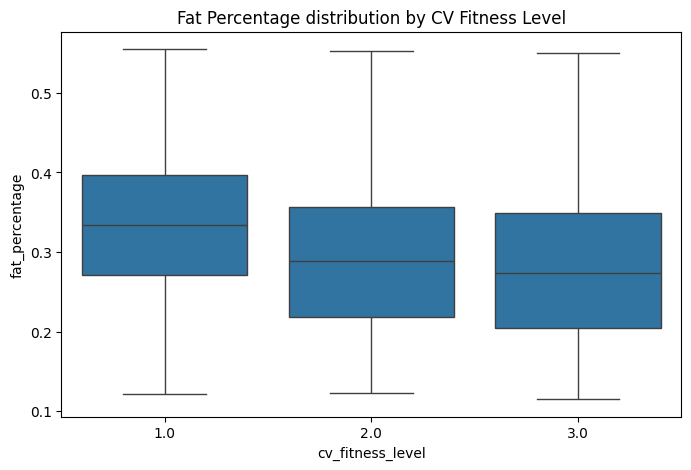

In [143]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(x='cv_fitness_level', y='fat_percentage', data=health_data_with_cv)
plt.title("Fat Percentage distribution by CV Fitness Level")
plt.show()


In [184]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE

## Load and Merge Data
Load the cleaned dataset and merge it with cardiovascular fitness data.

In [185]:
data_path = "data/nhanes_cleaned_validated_data.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Ensure the preprocessing step was completed.")

health_data = pd.read_csv(data_path)
print(f"Loaded main dataset with shape: {health_data.shape}")

# Load and merge cardiovascular fitness data
cv_data1 = pd.read_csv('csv/1999_2000/cv_level.csv')
cv_data2 = pd.read_csv('csv/2001_2002/cv_level.csv')
cv_data3 = pd.read_csv('csv/2003_2004/cv_level.csv')

cv_data = pd.concat([cv_data1, cv_data2, cv_data3], ignore_index=True)
health_data_with_cv = health_data.merge(cv_data, on='id', how='inner').dropna()

bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']

# Apply BMI categorization
health_data_with_cv['bmi_category'] = pd.cut(health_data_with_cv['bmi'], bins=bmi_bins, labels=bmi_labels)

health_data_with_cv['fat_percentage'] = health_data_with_cv['total_fat_mass'] / (
    health_data_with_cv['total_fat_mass'] + health_data_with_cv['total_lean_mass']
)

print(f"Merged dataset with CV-level. Shape: {health_data_with_cv.shape}")


Loaded main dataset with shape: (14740, 15)
Merged dataset with CV-level. Shape: (5177, 18)


## Define Feature Sets (With & Without TLM/TFM)
Specify which features will be included for each clustering approach.

In [186]:
# Common numeric features
# numerical_features_common = ['bmi', 'age_in_months']
# numerical_features_common = ['bmi']

# Features WITH TLM/TFM
# numerical_features_tlm_tfm = ['total_fat_mass', 'total_lean_mass']
# numerical_features_tlm_tfm = ['fat_percentage']

# Define feature sets
# numerical_features_with = numerical_features_common + numerical_features_tlm_tfm
# numerical_features_without = numerical_features_common + ['weight', 'height', 'maximal_calf_circumference',
#                                                           'arm_circumference', 'waist_circumference', 'thigh_circumference']

# Categorical features (for encoding)
# categorical_features = ['gender', 'ethnicity', 'cv_fitness_level']
# categorical_features = ['cv_fitness_level']

numerical_features_with = ['bmi', 'fat_percentage']
numerical_features_without = ['weight', 'height', 'bmi', 
                              'maximal_calf_circumference', 
                              'arm_circumference', 
                              'waist_circumference', 
                              'thigh_circumference', 
                              'age_in_months']

categorical_features_with = ['cv_fitness_level']
categorical_features_without = ['gender', 'ethnicity', 'cv_fitness_level']

## Encode and Scale Data
Encode categorical features and standardize numerical features.

In [187]:
encoder_with = OneHotEncoder(drop='first', sparse_output=False)
encoder_without = OneHotEncoder(drop='first', sparse_output=False)

encoded_categorical_with = encoder_with.fit_transform(health_data_with_cv[categorical_features_with])
encoded_df_with = pd.DataFrame(encoded_categorical_with, columns=encoder_with.get_feature_names_out(categorical_features_with),
                          index=health_data_with_cv.index)

encoded_categorical_without = encoder_without.fit_transform(health_data_with_cv[categorical_features_without])
encoded_df_without = pd.DataFrame(encoded_categorical_without, columns=encoder_without.get_feature_names_out(categorical_features_without),
                          index=health_data_with_cv.index)

scaler = StandardScaler()
data_with_scaled = scaler.fit_transform(pd.concat([health_data_with_cv[numerical_features_with], encoded_df_with], axis=1))
data_without_scaled = scaler.fit_transform(pd.concat([health_data_with_cv[numerical_features_without], encoded_df_without], axis=1))

## Find Optimal Number of Clusters (Using BIC & AIC)
Determine the best K for Gaussian Mixture Model (GMM) clustering.

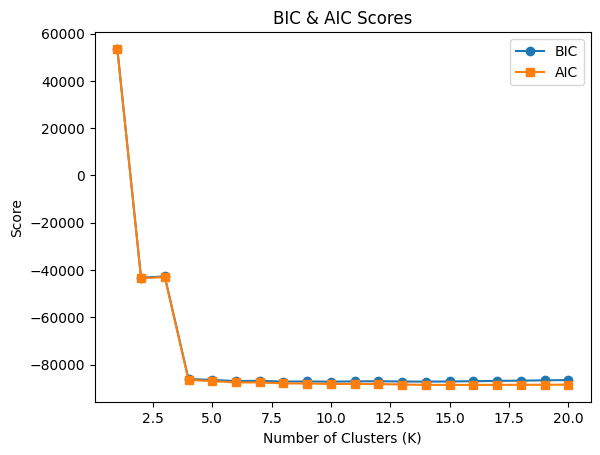

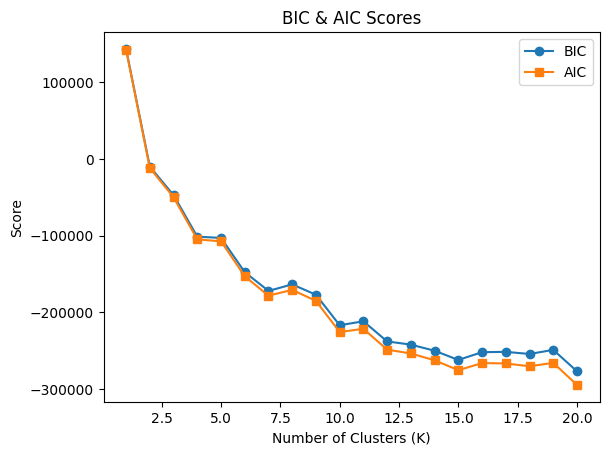

Optimal K (WITH TLM/TFM): 10
Optimal K (WITHOUT TLM/TFM): 20


In [188]:
def find_optimal_k(data_scaled, k_range=range(1, 21)):
    bic_scores = []
    aic_scores = []
    
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data_scaled)
        bic_scores.append(gmm.bic(data_scaled))
        aic_scores.append(gmm.aic(data_scaled))
    
    # Plot BIC/AIC scores
    plt.figure()
    plt.plot(k_range, bic_scores, marker='o', label="BIC")
    plt.plot(k_range, aic_scores, marker='s', label="AIC")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Score")
    plt.legend()
    plt.title("BIC & AIC Scores")
    plt.show()
    
    return k_range[np.argmin(bic_scores)]

optimal_k_with = find_optimal_k(data_with_scaled)
optimal_k_without = find_optimal_k(data_without_scaled)

print(f"Optimal K (WITH TLM/TFM): {optimal_k_with}")
print(f"Optimal K (WITHOUT TLM/TFM): {optimal_k_without}")

## Perform Clustering with GMM
Run Gaussian Mixture Model clustering for both cases.

In [189]:
gmm_with = GaussianMixture(n_components=optimal_k_with, random_state=42, reg_covar=1e-2)
clusters_with = gmm_with.fit_predict(data_with_scaled)

gmm_without = GaussianMixture(n_components=optimal_k_without, random_state=42, reg_covar=1e-2)
clusters_without = gmm_without.fit_predict(data_without_scaled)

health_data_with_cv["cluster_with"] = clusters_with
health_data_with_cv["cluster_without"] = clusters_without

In [190]:
from sklearn.tree import DecisionTreeClassifier

# Train a tree model to predict clusters
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(data_with_scaled, clusters_with)

# Get all feature names (numerical + encoded categorical)
feature_names = numerical_features_with + list(encoder_with.get_feature_names_out(categorical_features_with))
print(f"Total feature names: {len(feature_names)}")

# Get feature importances
feature_importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Display important features
print("Key Features for Clustering Decision:")
print(feature_importances.head(10))


Total feature names: 4
Key Features for Clustering Decision:
fat_percentage          0.484584
cv_fitness_level_2.0    0.229757
cv_fitness_level_3.0    0.174578
bmi                     0.111081
dtype: float64


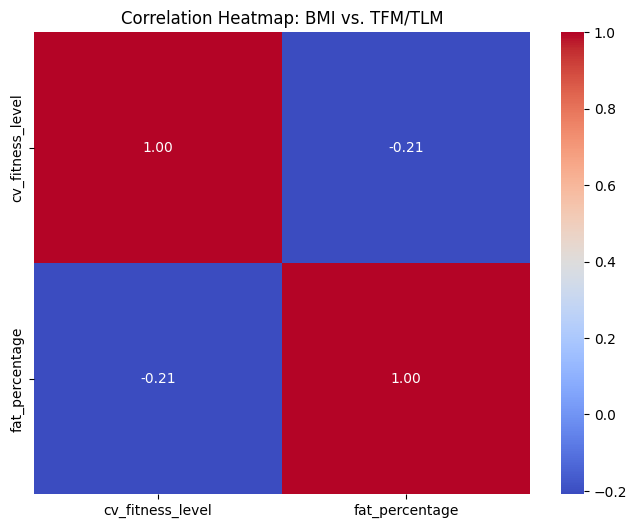

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = health_data_with_cv[['cv_fitness_level', 'fat_percentage']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: BMI vs. TFM/TLM")
plt.show()


## Evaluate Clustering Performance
Compute silhouette, Davies-Bouldin, and Calinski-Harabasz scores.

In [191]:
def evaluate_clusters(data_scaled, labels, description):
    silhouette = silhouette_score(data_scaled, labels)
    davies_bouldin = davies_bouldin_score(data_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
    
    print(f"Clustering Quality ({description}):")
    print(f"  - Silhouette Score: {silhouette:.4f} (higher is better)")
    print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
    print(f"  - Calinski-Harabasz Index: {calinski_harabasz:.4f} (higher is better)\n")

evaluate_clusters(data_with_scaled, clusters_with, "With TLM/TFM")
evaluate_clusters(data_without_scaled, clusters_without, "Without TLM/TFM")

Clustering Quality (With TLM/TFM):
  - Silhouette Score: 0.3742 (higher is better)
  - Davies-Bouldin Index: 0.8912 (lower is better)
  - Calinski-Harabasz Index: 3285.5991 (higher is better)

Clustering Quality (Without TLM/TFM):
  - Silhouette Score: 0.1305 (higher is better)
  - Davies-Bouldin Index: 1.8755 (lower is better)
  - Calinski-Harabasz Index: 340.4004 (higher is better)



## Compare Clustering Overlap (ARI & NMI)
Use Adjusted Rand Index (ARI) and Normalized Mutual Info (NMI).

In [192]:
ari = adjusted_rand_score(clusters_with, clusters_without)
nmi = normalized_mutual_info_score(clusters_with, clusters_without)

print("\n=== Clustering Overlap Metrics ===")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")


=== Clustering Overlap Metrics ===
Adjusted Rand Index (ARI): 0.2162
Normalized Mutual Info (NMI): 0.3881


## Visualize Clusters with t-SNE
Reduce dimensionality to 2D for visualization.

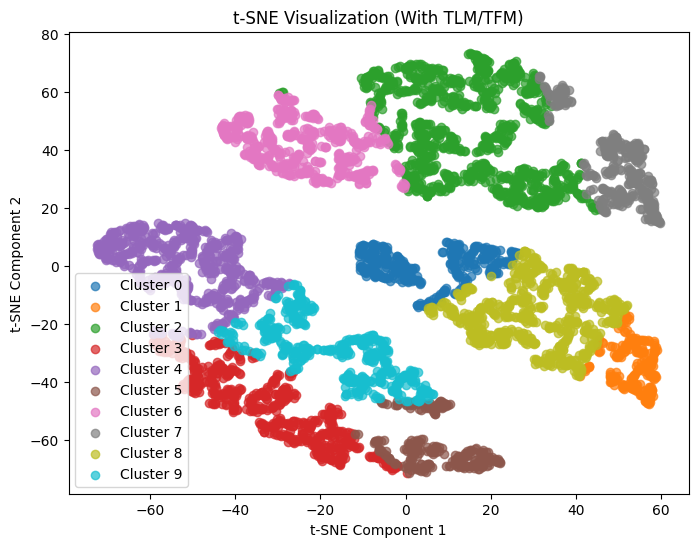

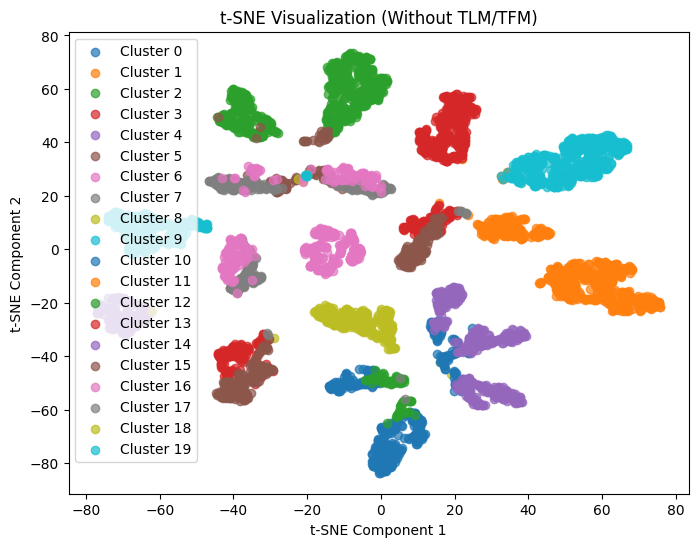

In [193]:
def plot_tsne(data_scaled, clusters, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(data_scaled)

    plt.figure(figsize=(8, 6))
    for cluster_id in np.unique(clusters):
        subset = tsne_result[clusters == cluster_id]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
    
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(title)
    plt.legend()
    plt.show()

plot_tsne(data_with_scaled, clusters_with, "t-SNE Visualization (With TLM/TFM)")
plot_tsne(data_without_scaled, clusters_without, "t-SNE Visualization (Without TLM/TFM)")

## For future: Creating subgroups for every clusters(now max 10 participants)

In [10]:
from sklearn.cluster import AgglomerativeClustering

def get_leaves(node_id, children, n_samples):
    stack = [node_id]
    leaves = []
    while stack:
        curr = stack.pop()
        if curr < n_samples:
            leaves.append(curr)
        else:
            child_left, child_right = children[curr - n_samples]
            stack.append(child_left)
            stack.append(child_right)
    return leaves

def cut_dendrogram_max_size(children, n_samples, max_size=10):
    root_id = 2 * n_samples - 2
    clusters = []
    
    stack = [root_id]
    while stack:
        node = stack.pop()
        leaves = get_leaves(node, children, n_samples)
        if len(leaves) <= max_size:
            clusters.append(leaves)
        else:
            if node < n_samples:
                clusters.append([node])
                continue
            left_child, right_child = children[node - n_samples]
            stack.append(left_child)
            stack.append(right_child)
    return clusters

def visualize_cluster_subgroups(
    cluster_df, 
    numerical_features, 
    categorical_features,
    max_subgroup_size=10
):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_categorical = encoder.fit_transform(cluster_df[categorical_features])
    encoded_df = pd.DataFrame(
        encoded_categorical, 
        columns=encoder.get_feature_names_out(categorical_features)
    )

    data = pd.concat([cluster_df[numerical_features].reset_index(drop=True), encoded_df], axis=1)

    data_scaled = (data - data.mean()) / data.std()

    n_samples = len(data_scaled)
    agglo = AgglomerativeClustering(
        n_clusters=None, 
        distance_threshold=0  # Forces building the full tree
    )
    agglo.fit(data_scaled)


    children_ = agglo.children_
    clusters_list = cut_dendrogram_max_size(children_, n_samples, max_size=max_subgroup_size)

    final_labels = np.empty(n_samples, dtype=int)
    for label_id, leaf_indices in enumerate(clusters_list):
        for idx in leaf_indices:
            final_labels[idx] = label_id

    cluster_df = cluster_df.copy()
    cluster_df["subgroup"] = final_labels
    
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    data_tsne = tsne.fit_transform(data_scaled)

    plt.figure(figsize=(8, 6))
    num_subgroups = len(clusters_list)
    colors = plt.cm.get_cmap("gist_ncar", num_subgroups)

    for subgroup_label in range(num_subgroups):
        indices = (final_labels == subgroup_label)
        plt.scatter(
            data_tsne[indices, 0],
            data_tsne[indices, 1],
            color=colors(subgroup_label % 10),
            label=f"Subgroup {subgroup_label}",
            alpha=0.7,
            edgecolors="black"
        )

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"Enforced ≤{max_subgroup_size} via Dendrogram Cut")
    plt.legend()
    plt.show()

    return cluster_df

def process_and_visualize_single_cluster(
    combined_df, 
    cluster_id, 
    numerical_features, 
    categorical_features, 
    max_subgroup_size=10
):
    cluster_df = combined_df[combined_df["cluster_with"] == cluster_id]

    if len(cluster_df) <= max_subgroup_size:
        cluster_df = cluster_df.copy()
        cluster_df["subgroup"] = 0
        return cluster_df

    updated_cluster_df = visualize_cluster_subgroups(
        cluster_df,
        numerical_features,
        categorical_features,
        max_subgroup_size
    )
    return updated_cluster_df

C:\Users\Pizhuk\AppData\Local\Temp\ipykernel_30972\3147515558.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("gist_ncar", num_subgroups)


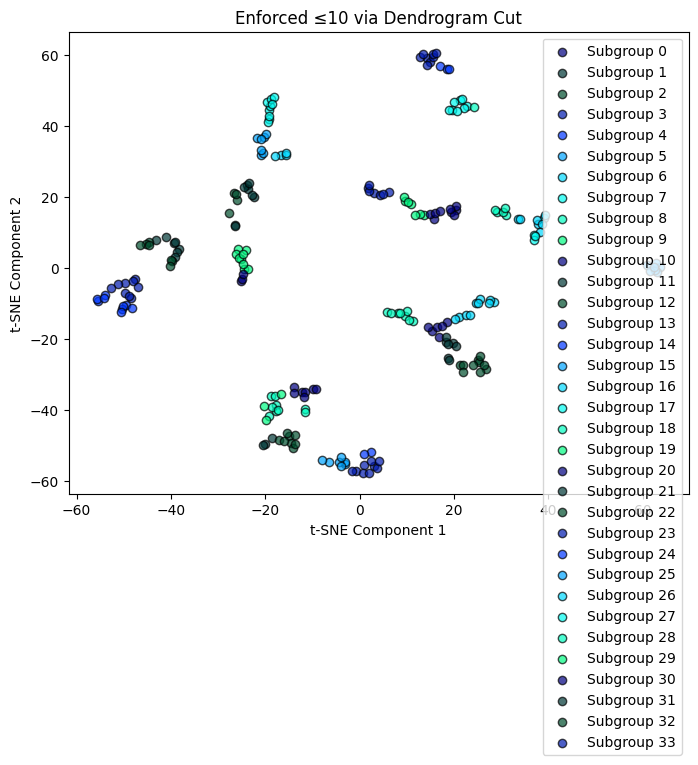

In [11]:
cluster_5_df = process_and_visualize_single_cluster(
    health_data_with_cv, 
    cluster_id=5, 
    numerical_features=["bmi", "age_in_months", "total_fat_mass", "total_lean_mass"], 
    categorical_features=["gender", "ethnicity", "cv_fitness_level"],
    max_subgroup_size=10
)

In [12]:
# subgroup_stats = cluster_5_df.groupby("subgroup")[numerical_features].describe()
# subgroup_stats.to_csv("subgroup_statistics.csv")